In [28]:
import time
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import read_excel, DataFrame, concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM




In [29]:
# Load dataset
file_path = 'AI-Sediments results.xlsx'
dataset = read_excel(file_path)

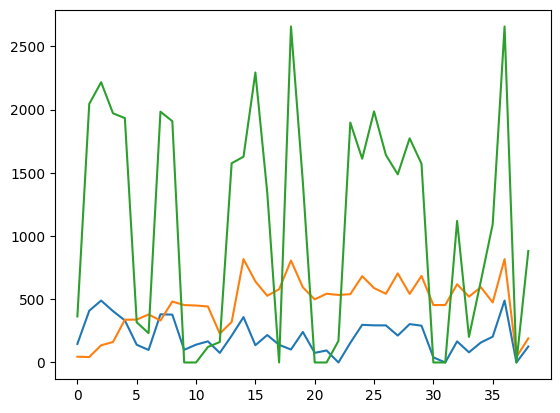

In [30]:
# Select relevant columns (assuming Potassium, Sodium, and Magnesium are represented by 'NiO', 'CdO', 'ZnO')
values = dataset[['NiO', 'CdO', 'ZnO']].values

plt.figure(1)
plt.plot(values)
plt.show()


In [31]:
# Ensure all data is float
values = values.astype('float32')

In [32]:
# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


In [33]:
# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

reframed = series_to_supervised(scaled, 1, 1)
print(reframed.head())


   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)   var2(t)   var3(t)
1   0.300758   0.003703   0.136973  0.835611  0.000000  0.769652
2   0.835611   0.000000   0.769652  1.000000  0.120394  0.834189
3   1.000000   0.120394   0.834189  0.829545  0.153214  0.741692
4   0.829545   0.153214   0.741692  0.679554  0.381055  0.727209
5   0.679554   0.381055   0.727209  0.286053  0.382294  0.119585


In [34]:
# Split into train and test sets
values = reframed.values
n_train_hours = int(len(values) * 0.8)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]


In [35]:
# Split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]


In [36]:
# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(30, 1, 5) (30,) (8, 1, 5) (8,)


In [37]:
# Design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation("linear"))

start = time.time()
model.compile(loss="mse", optimizer="adam")
print("Compilation Time : ", time.time() - start)

Compilation Time :  0.0029997825622558594


c:\Users\Nightroo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [38]:
# Fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/50
1/1 - 1s - 1s/step - loss: 0.3010 - val_loss: 0.1663
Epoch 2/50
1/1 - 0s - 38ms/step - loss: 0.2932 - val_loss: 0.1605
Epoch 3/50
1/1 - 0s - 38ms/step - loss: 0.2821 - val_loss: 0.1548
Epoch 4/50
1/1 - 0s - 38ms/step - loss: 0.2779 - val_loss: 0.1494
Epoch 5/50
1/1 - 0s - 37ms/step - loss: 0.2570 - val_loss: 0.1441
Epoch 6/50
1/1 - 0s - 40ms/step - loss: 0.2589 - val_loss: 0.1390
Epoch 7/50
1/1 - 0s - 42ms/step - loss: 0.2521 - val_loss: 0.1341
Epoch 8/50
1/1 - 0s - 46ms/step - loss: 0.2439 - val_loss: 0.1293
Epoch 9/50
1/1 - 0s - 38ms/step - loss: 0.2292 - val_loss: 0.1248
Epoch 10/50
1/1 - 0s - 40ms/step - loss: 0.2184 - val_loss: 0.1204
Epoch 11/50
1/1 - 0s - 39ms/step - loss: 0.2167 - val_loss: 0.1161
Epoch 12/50
1/1 - 0s - 41ms/step - loss: 0.2115 - val_loss: 0.1121
Epoch 13/50
1/1 - 0s - 39ms/step - loss: 0.1991 - val_loss: 0.1082
Epoch 14/50
1/1 - 0s - 40ms/step - loss: 0.1968 - val_loss: 0.1045
Epoch 15/50
1/1 - 0s - 39ms/step - loss: 0.1878 - val_loss: 0.1009
Epoch 

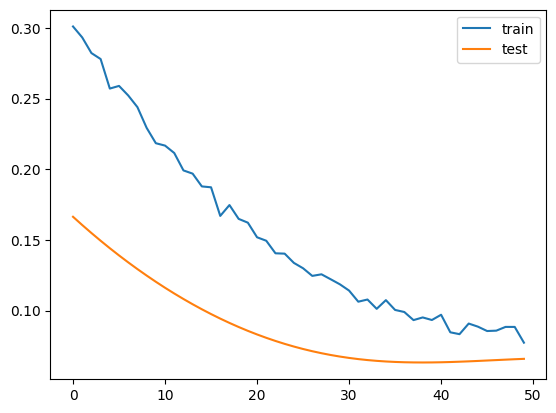

In [39]:
# Plot history
plt.figure(2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [40]:
# Make a prediction
train_xhat = model.predict(train_X)
yhat = model.predict(test_X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


In [41]:
# Prepare for inverse transformation
train_X_reshaped = train_X.reshape((train_X.shape[0], train_X.shape[2]))
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [42]:
# Create empty arrays with the same shape as the scaled data for concatenation
trainPredict = np.empty_like(scaled)
testPredict = np.empty_like(scaled)


In [43]:
# Only keep the last column (the prediction) in the position it was originally
trainPredict[:, :-1] = train_X_reshaped[:, :-1]
trainPredict[:, -1] = train_xhat[:, 0]
testPredict[:, :-1] = test_X_reshaped[:, :-1]
testPredict[:, -1] = yhat[:, 0]

ValueError: could not broadcast input array from shape (30,4) into shape (39,2)

In [ ]:
# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)[:, -1]
testPredict = scaler.inverse_transform(testPredict)[:, -1]

In [ ]:
# Prepare plots
look_back = 1
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, -1] = trainPredict

testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + look_back - 1:len(scaled) - 1, -1] = testPredict

plt.figure(3)
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot, label='Train Prediction')
plt.plot(testPredictPlot, label='Test Prediction')
plt.legend()
plt.show()


ValueError: could not broadcast input array from shape (39,) into shape (38,)

In [ ]:
# Invert scaling for forecast
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]


ValueError: operands could not be broadcast together with shapes (8,5) (3,) (8,5) 

In [ ]:
# Invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

ValueError: operands could not be broadcast together with shapes (8,5) (3,) (8,5) 

In [ ]:
# Calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.115


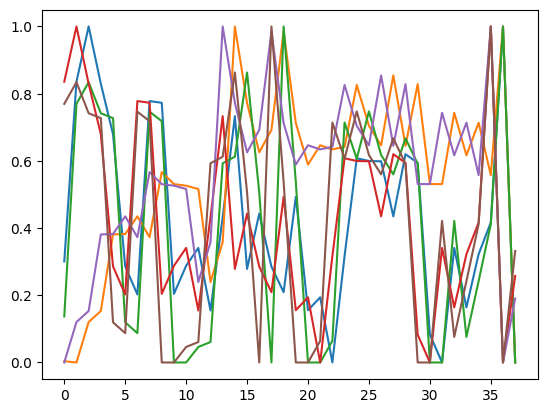

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)  \
1   0.300758   0.003703   0.136973   0.835611   0.000000   0.769652  0.835611   
2   0.835611   0.000000   0.769652   1.000000   0.120394   0.834189  1.000000   
3   1.000000   0.120394   0.834189   0.829545   0.153214   0.741692  0.829545   
4   0.829545   0.153214   0.741692   0.679554   0.381055   0.727209  0.679554   
5   0.679554   0.381055   0.727209   0.286053   0.382294   0.119585  0.286053   

    var2(t)   var3(t)   var4(t)   var5(t)   var6(t)  
1  0.000000  0.769652  1.000000  0.120394  0.834189  
2  0.120394  0.834189  0.829545  0.153214  0.741692  
3  0.153214  0.741692  0.679554  0.381055  0.727209  
4  0.381055  0.727209  0.286053  0.382294  0.119585  
5  0.382294  0.119585  0.202439  0.434869  0.087292  
(29, 1, 9) (29, 3) (8, 1, 9) (8, 3)
Compilation Time :  0.0029981136322021484
Epoch 1/50


c:\Users\Nightroo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 - 1s - 1s/step - loss: 0.3460 - val_loss: 0.2734
Epoch 2/50
1/1 - 0s - 41ms/step - loss: 0.3386 - val_loss: 0.2671
Epoch 3/50
1/1 - 0s - 41ms/step - loss: 0.3362 - val_loss: 0.2609
Epoch 4/50
1/1 - 0s - 41ms/step - loss: 0.3145 - val_loss: 0.2550
Epoch 5/50
1/1 - 0s - 39ms/step - loss: 0.3163 - val_loss: 0.2493
Epoch 6/50
1/1 - 0s - 38ms/step - loss: 0.3024 - val_loss: 0.2437
Epoch 7/50
1/1 - 0s - 39ms/step - loss: 0.2951 - val_loss: 0.2382
Epoch 8/50
1/1 - 0s - 38ms/step - loss: 0.2811 - val_loss: 0.2329
Epoch 9/50
1/1 - 0s - 42ms/step - loss: 0.2782 - val_loss: 0.2278
Epoch 10/50
1/1 - 0s - 39ms/step - loss: 0.2629 - val_loss: 0.2228
Epoch 11/50
1/1 - 0s - 44ms/step - loss: 0.2585 - val_loss: 0.2179
Epoch 12/50
1/1 - 0s - 42ms/step - loss: 0.2515 - val_loss: 0.2132
Epoch 13/50
1/1 - 0s - 40ms/step - loss: 0.2435 - val_loss: 0.2086
Epoch 14/50
1/1 - 0s - 43ms/step - loss: 0.2390 - val_loss: 0.2041
Epoch 15/50
1/1 - 0s - 40ms/step - loss: 0.2293 - val_loss: 0.1997
Epoch 16/50
1/1 -

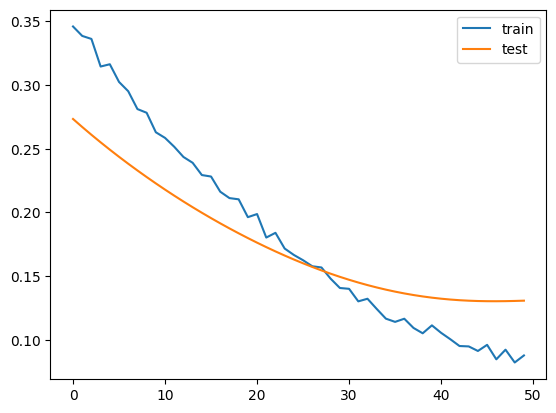

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ValueError: could not broadcast input array from shape (29,9) into shape (38,3)

In [44]:
plt.figure(1)
plt.plot(values)
plt.show()

# Ensure all data is float
values = values.astype('float32')

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

reframed = series_to_supervised(scaled, 1, 1)
print(reframed.head())

# Split into train and test sets
values = reframed.values
n_train_hours = int(len(values) * 0.8)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# Split into input and outputs
train_X, train_y = train[:, :-3], train[:, -3:]
test_X, test_y = test[:, :-3], test[:, -3:]

# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# Design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(3))  # Output layer with 3 units for 3 predictions
model.add(Activation("linear"))

start = time.time()
model.compile(loss="mse", optimizer="adam")
print("Compilation Time : ", time.time() - start)

# Fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# Plot history
plt.figure(2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Make a prediction
train_xhat = model.predict(train_X)
yhat = model.predict(test_X)

# Prepare for inverse transformation
train_X_reshaped = train_X.reshape((train_X.shape[0], train_X.shape[2]))
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Create empty arrays with the same shape as the scaled data for concatenation
trainPredict = np.empty_like(scaled)
testPredict = np.empty_like(scaled)

# Only keep the last columns (the predictions) in the positions they were originally
trainPredict[:, :-3] = train_X_reshaped
trainPredict[:, -3:] = train_xhat
testPredict[:, :-3] = test_X_reshaped
testPredict[:, -3:] = yhat

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)[:, -3:]
testPredict = scaler.inverse_transform(testPredict)[:, -3:]

# Prepare plots
look_back = 1
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, -3:] = trainPredict

testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + look_back - 1:len(scaled) - 1, -3:] = testPredict

plt.figure(3)
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot, label='Train Prediction')
plt.plot(testPredictPlot, label='Test Prediction')
plt.legend()
plt.show()

# Invert scaling for forecast
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, :3]

# Invert scaling for actual
test_y = test_y.reshape((len(test_y), 3))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, :3]

# Calculate RMSE for each element
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

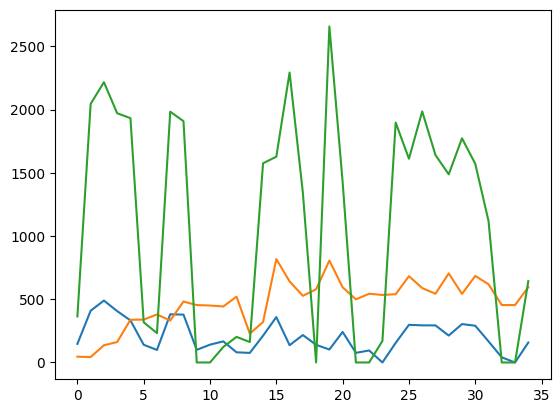

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)   var2(t)   var3(t)
1   0.300758   0.003703   0.136973  0.835611  0.000000  0.769652
2   0.835611   0.000000   0.769652  1.000000  0.120394  0.834189
3   1.000000   0.120394   0.834189  0.829545  0.153214  0.741692
4   0.829545   0.153214   0.741692  0.679554  0.381055  0.727209
5   0.679554   0.381055   0.727209  0.286053  0.382294  0.119585
(27, 1, 3) (27, 3) (7, 1, 3) (7, 3)
Compilation Time :  0.003001689910888672
Epoch 1/50


c:\Users\Nightroo\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 - 1s - 1s/step - loss: 0.3049 - val_loss: 0.2770
Epoch 2/50
1/1 - 0s - 42ms/step - loss: 0.3058 - val_loss: 0.2724
Epoch 3/50
1/1 - 0s - 43ms/step - loss: 0.3001 - val_loss: 0.2678
Epoch 4/50
1/1 - 0s - 42ms/step - loss: 0.2967 - val_loss: 0.2632
Epoch 5/50
1/1 - 0s - 38ms/step - loss: 0.2884 - val_loss: 0.2587
Epoch 6/50
1/1 - 0s - 41ms/step - loss: 0.2854 - val_loss: 0.2542
Epoch 7/50
1/1 - 0s - 41ms/step - loss: 0.2807 - val_loss: 0.2497
Epoch 8/50
1/1 - 0s - 41ms/step - loss: 0.2810 - val_loss: 0.2452
Epoch 9/50
1/1 - 0s - 39ms/step - loss: 0.2770 - val_loss: 0.2408
Epoch 10/50
1/1 - 0s - 41ms/step - loss: 0.2717 - val_loss: 0.2364
Epoch 11/50
1/1 - 0s - 40ms/step - loss: 0.2657 - val_loss: 0.2320
Epoch 12/50
1/1 - 0s - 40ms/step - loss: 0.2622 - val_loss: 0.2277
Epoch 13/50
1/1 - 0s - 38ms/step - loss: 0.2546 - val_loss: 0.2233
Epoch 14/50
1/1 - 0s - 40ms/step - loss: 0.2554 - val_loss: 0.2190
Epoch 15/50
1/1 - 0s - 41ms/step - loss: 0.2503 - val_loss: 0.2148
Epoch 16/50
1/1 -

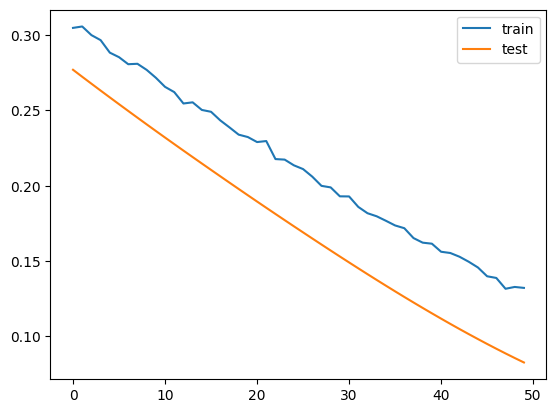

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


ValueError: could not broadcast input array from shape (27,3) into shape (35,0)

In [52]:
import time
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import read_excel, DataFrame, concat, to_datetime, DateOffset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM

# Load dataset
file_path = 'Sediments resultsv2.xlsx'
dataset = read_excel(file_path)

# Convert the date column to datetime format starting from March
dataset['date'] = to_datetime(dataset['date'], format='%d-%m-%Y') + DateOffset(months=2)

# Sort the dataset by date
dataset = dataset.sort_values(by='date')

# Select relevant columns (assuming Potassium, Sodium, and Magnesium are represented by 'NiO', 'CdO', 'ZnO')
values = dataset[['Ni', 'Cd', 'Zn']].values

plt.figure(1)
plt.plot(values)
plt.show()

# Ensure all data is float
values = values.astype('float32')

# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

reframed = series_to_supervised(scaled, 1, 1)
print(reframed.head())

# Split into train and test sets
values = reframed.values
n_train_hours = int(len(values) * 0.8)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# Split into input and outputs
train_X, train_y = train[:, :-3], train[:, -3:]
test_X, test_y = test[:, :-3], test[:, -3:]

# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# Design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(3))  # Output layer with 3 units for 3 predictions
model.add(Activation("linear"))

start = time.time()
model.compile(loss="mse", optimizer="adam")
print("Compilation Time : ", time.time() - start)

# Fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# Plot history
plt.figure(2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Make a prediction
train_xhat = model.predict(train_X)
yhat = model.predict(test_X)

# Prepare for inverse transformation
train_X_reshaped = train_X.reshape((train_X.shape[0], train_X.shape[2]))
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# Create empty arrays with the same shape as the scaled data for concatenation
trainPredict = np.empty_like(scaled)
testPredict = np.empty_like(scaled)

# Only keep the last columns (the predictions) in the positions they were originally
trainPredict[:, :-3] = train_X_reshaped
trainPredict[:, -3:] = train_xhat
testPredict[:, :-3] = test_X_reshaped
testPredict[:, -3:] = yhat

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)[:, -3:]
testPredict = scaler.inverse_transform(testPredict)[:, -3:]

# Prepare plots
look_back = 1
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, -3:] = trainPredict

testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + look_back - 1:len(scaled) - 1, -3:] = testPredict

plt.figure(3)
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot, label='Train Prediction')
plt.plot(testPredictPlot, label='Test Prediction')
plt.legend()
plt.show()

# Predict future values up to 2030
future_weeks = (2030 - dataset['date'].dt.year.max()) * 52  # Number of weeks until 2030
future_predictions = []

last_observation = scaled[-1].reshape(1, 1, -1)
for _ in range(future_weeks):
    future_pred = model.predict(last_observation)
    future_predictions.append(future_pred[0])
    last_observation = np.roll(last_observation, -1, axis=2)
    last_observation[0, 0, -3:] = future_pred

future_predictions = np.array(future_predictions)
future_predictions = scaler.inverse_transform(future_predictions)

# Create future dates
last_date = dataset['date'].max()
future_dates = [last_date + DateOffset(weeks=i) for i in range(1, future_weeks + 1)]

# Plot future predictions
plt.figure(4)
plt.plot(future_dates, future_predictions, label='Future Predictions')
plt.legend()
plt.show()